**POZOR: Ak používate počítač, ktorého GPU nepodporuje prostredie CUDA, môžete na akceleráciu učenia použiť Google Colab notebook s GPU podporou.**

# Zhlukovanie ľudských tvárí

V tomto notebook-u ukážeme, ako sa dá v Python-e jednoducho realizovať zhlukovanie ľudských tvárí. Kód je založený na [blog-u](https://www.pyimagesearch.com/2018/07/09/face-clustering-with-python/) Adriana Rosebrocka.

## Stiahnutie kódu a načítanie modelu

Na začiatku si nainštalujeme niekoľko balíčkov, ktoré budeme potrebovať.

In [2]:
!pip install face_recognition imutils sklearn google-images-download lapjv

     |████████████████████████████████| 100.2MB 347kB/s 
     |████████████████████████████████| 911kB 40.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/9a/98/65/c1313c5ed4a9d5a6c6620cc92b167d8b637c3a9d05a2511bb9
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built google-images-download face-recognition-models


Importujeme potrebné balíčky:

In [0]:
%matplotlib inline
import os
import shutil
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import cv2

from lapjv import lapjv
from scipy.spatial.distance import cdist

In [0]:
#@title >> SKRYTÁ IMPLEMENTÁCIA RUTÍN << { display-mode: "form" }
import face_recognition
import cv2
import os
import glob
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np

def get_image_filenames(
    directory,
    image_exts = ['.jpg', '.jpeg', '.png', '.gif'],
    recursive = True
):
    images = []
    
    for fname in glob.glob(os.path.join(directory, "**/*"), recursive=recursive):
        if os.path.isfile(fname) and os.path.splitext(fname)[-1] in image_exts:
            images.append(fname)
    
    return images

def enforce_maxres(image, max_resolution):
    height, width = image.shape[:2]
    
    if width > height:
        if width > max_resolution:
            width, height = max_resolution, max_resolution / width * height
            image = cv2.resize(image, (int(width), int(height)))
    else:
        if height > max_resolution:
            width, height = max_resolution / height * width, max_resolution
            image = cv2.resize(image, (int(width), int(height)))
            
    return image

def encode_image(image, imagePath, 
                 detection_method="cnn",
                 max_resolution=1800):
    """
    detection_method: "cnn" or "hog"
    """
    image = enforce_maxres(image, max_resolution)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # detect the (x, y)-coordinates of the bounding boxes
    # corresponding to each face in the input image
    boxes = face_recognition.face_locations(rgb,
        model=detection_method)

    # compute the facial embedding for the face
    encodings = face_recognition.face_encodings(rgb, boxes)

    # build a dictionary of the image path, bounding box location,
    # and facial encodings for the current image
    d = [{"imagePath": imagePath, "loc": box,
          "encoding": enc, 'shape': image.shape}
                for (box, enc) in zip(boxes, encodings)]
    
    return d
    
def encode_dataset(dataset_path, detection_method,
                   verbose=1, max_resolution=1800):
    imagePaths = get_image_filenames(dataset_path)
    data = []
    
    for (i, imagePath) in enumerate(imagePaths):
        # load the input image and convert it from RGB (OpenCV ordering)
        # to dlib ordering (RGB)
        if verbose:
            print("Processing image {}/{}".format(i + 1,
                len(imagePaths)))
            print(imagePath)

        image = cv2.imread(imagePath)
        
        if image is None:
            if verbose:
                print("Skipping '{}'; the file cannot be opened.".format(
                        imagePath))
            continue
        
        d = encode_image(image, imagePath, detection_method=detection_method,
                         max_resolution=max_resolution)
        data.extend(d)
        
    if verbose:
        print("Found the total of {} face boxes.".format(len(data)))

    return data

def plot_clusters(data, clt, labelIDs, verbose=1, figsize=(10, 8)):
    # loop over the unique face integers
    for labelID in labelIDs:
        # find all indexes into the `data` array that belong to the
        # current label ID, then randomly sample a maximum of 25 indexes
        # from the set
        if verbose:
            print("Faces for face ID: {}".format(labelID))
        
        idxs = np.where(clt.labels_ == labelID)[0]
        idxs = np.random.choice(idxs, size=min(25, len(idxs)),
            replace=False)
    
        # initialize the list of faces to include in the montage
        faces = []
    
        # loop over the sampled indexes
        for i in idxs:
            # load the input image and extract the face ROI
            image = cv2.imread(data[i]["imagePath"])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            shape = data[i]["shape"]
            image = cv2.resize(image, (shape[1], shape[0]))
            
            (top, right, bottom, left) = data[i]["loc"]
            face = image[top:bottom, left:right]
    
            # force resize the face ROI to 96x96 and then add it to the
            # faces montage list
            face = cv2.resize(face, (96, 96))
            faces.append(face)
    
        # create a montage using 96x96 "tiles" with 5 rows and 5 columns
        montage = build_montages(faces, (96, 96), (5, 5))[0]
        
        # show the output montage
        title = "Face ID #{}".format(labelID)
        title = "Unknown Faces" if labelID == -1 else title
        
        plt.figure(figsize=figsize)
        plt.imshow(montage)
        plt.title(title)

## Parametre

In [0]:
# Cesta ku priečinku, v ktorom budú obrázky.
dataset_path = "dataset"

# Metóda na detekciu tvárí: "cnn" alebo "hog".
# CNN je presnejšia, ale HoG je trochu rýchlejšia, najmä
# ak sa nepoužíva GPU na akceleráciu.
detection_method = "cnn"

# Počet paralelných vlákien, ktoré sa použijú na zhlukovanie
# (-1 znamená použiť všetky CPU).
num_jobs = -1

## Sťahovanie obrázkov

Ďalej budeme potrebovať obrázky tvárí, ktoré budeme zhlukovať. Použijeme preto balíček ``googleimagesdownload`` pomocou ktorého si stiahneme niekoľko obrázkov zo služby Google Images – napríklad fotografie známych osobností.

Do zoznamu  ``keywords`` zapíšeme ich mená.

In [0]:
keywords = [
    "Stephen Chbosky",
    "J. K. Rowling",
    "Philip Pullman",
    "Geoffrey Hinton",
    "George R. R. Martin",
    "Patrick Rothfuss"  
]

Pre každé z kľúčových slov teraz stiahneme niekoľko obrázkov a uložíme ich v priečinku ``downloads``.

In [7]:
for k in keywords:
  !googleimagesdownload -k "$k" --limit=25


Item no.: 1 --> Item name = Stephen Chbosky
Evaluating...
Starting Download...
Completed Image ====> 1. stephen-chbosky.jpg
Completed Image ====> 2. stephen-chbosky-1843916.jpg
Completed Image ====> 3. 61669074.jpg
Completed Image ====> 4. 220px-Stephen_Chbosky%2C_Jericho_Panel_at_Comic_Con_SD_2006_cropped.jpg
Completed Image ====> 5. temp_file20141028-16184-lgagyy.jpeg
Completed Image ====> 6. 5064ab7306f9a.image.jpg
Completed Image ====> 7. MV5BMTYzODIyMTM0OF5BMl5BanBnXkFtZTcwMjI1MDgwOA@@._V1_.jpg
Completed Image ====> 8. stephenchbosky-640x360.jpg
Completed Image ====> 9. Chboskyphoto.jpg
Completed Image ====> 10. latest?cb=20190124233956.jpg
Completed Image ====> 11. chb__131010201837.jpg
Completed Image ====> 12. Stephen-Chbosky-4-1543526717.jpg
Completed Image ====> 13. 19_chbosky.jpg
Completed Image ====> 14. Stephen-Chbosky.jpg
Completed Image ====> 15. Stephen+Chbosky+Perks+Being+Wallflower+Premiere+3yCqw9GuQUel.jpg
Completed Image ====> 16. A686483_list_20180105192059.jpg
Co

Ďalej prejdeme všetky novostiahnuté podpriečinky priečinka ``downloads`` a súbory kopírujeme do priečinka ``dataset``, odkiaľ ich budeme následne čítať.

In [0]:
dataset_path = "dataset"

shutil.rmtree(dataset_path, ignore_errors=True)
os.makedirs(dataset_path)

for root, dirs, files in os.walk('downloads'):
   for file in files:
      src_file = os.path.join(root, file)
      dst_file = os.path.join(dataset_path, file)
      shutil.copy2(src_file, dst_file)

## Extrakcia a transformácia tvárí

Keďže obrázky, ktoré v príklade používame, sú stiahnuté priamo z Google Images, budú obsahovať nielen ľudské tváre, ale aj celé osoby a ďalšie objekty. Musíme z nich preto nejakou metódou tváre extrahovať. Ak sme vyššie zvolili možnosť detection_method = "cnn", použije sa na to metóda založená na konvolučných neurónových sieťach.

V ďalšom kroku použijeme inú hlbokú sieť na transformáciu obrázkov tvárí do novej reprezentácie, ktorá lepšie vyjadruje podobnosti a rozdiely medzi ľudskými tvárami, než by to dokázala surová pixelová reprezentácia. Sieť je predtrénovaná na dátovej množine v s veľkým množstvom tvárí, a to podľa schémy na obrázku.

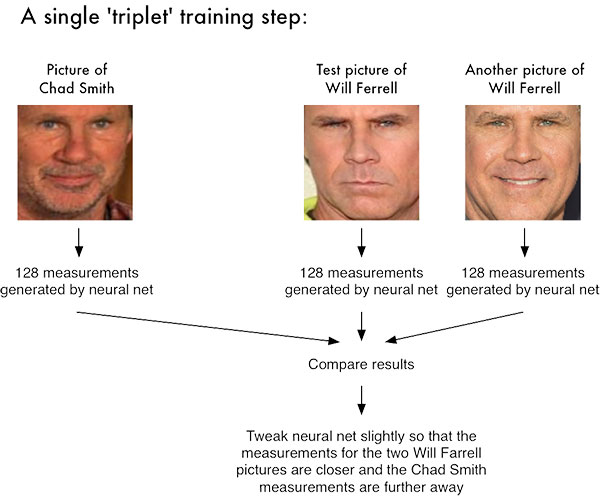
<center style="margin-top:20px">
    <a href="https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/">Face recognition with OpenCV, Python, and deep learning</a>
</center>

Každá tvár sa transformuje na 128-rozmerný vektor. Počas učenia sa sieti prezentujú trojice obrázkov. Dva z nich predstavujú dve odlišné fotografie tej istej osoby, zatiaľ čo tretí obrázok inej osoby. Úlohou siete je minimalizovať rozdiel medzi reprezentáciou fotografií toho isté človeka a maximalizovať rozdiel oproti fotografii inej osoby.

In [9]:
data = encode_dataset(dataset_path, detection_method)

Processing image 1/147
dataset/9. CMS_HoldingSig_900x510_0002_Layer-36.jpg
Processing image 2/147
dataset/22. 1*X4EOUNBpbKXiRhvNVeJRSw.jpeg
Processing image 3/147
dataset/8. 2017-07-04-Geoff%20Hinton_1%20%28web%20lead%29_1.jpg
Processing image 4/147
dataset/13. p04sy5xx.jpg
Processing image 5/147
dataset/20. 6886-177.jpg
Processing image 6/147
dataset/3. uploads%252Fcard%252Fimage%252F952633%252Fbc73bef0-f037-4639-893b-3ced06e3df85.jpg
Processing image 7/147
dataset/9. Chboskyphoto.jpg
Processing image 8/147
dataset/17. 5c8e75d5dd086121142ccfd3-750-563.jpg
Processing image 9/147
dataset/2. 04-george-rr-martin.w1200.h1500.jpg
Processing image 10/147
dataset/18. 31jmDDngx8L._UX250_.jpg
Processing image 11/147
dataset/13. TELEMMGLPICT000127720865_trans_NvBQzQNjv4Bq51xurVIoqhqRAGUjnLq19fd6RC4r-IBJ50TZTyTZmQs.jpeg
Processing image 12/147
dataset/14. GeoffHinton-TA-h_14977198.jpg
Processing image 13/147
dataset/17. lmb_geoffhinton.png
Processing image 14/147
dataset/25. patrick-rothfuss.jpg


Platí, že na extrahovaných obrázkoch sa môžu vyskytovať aj tváre iných osôb, než sme predpokladali (na pôvodných fotografiách mohli byť aj ďalší ľudia). Niektoré tváre môžu byť extrahované chybne, alebo sieť môže omylom namiesto tváre extrahovať inú časť fotografie. Uvidíme, ako sa s tým sieť extrahujúca 128-rozmerné reprezentácie vysporiada.

## Zhlukovanie

Následne z predspracovaných dát extrahujeme len vypočítané reprezentácie tvárí a vykonáme zhlukovanie pomocou metódy DBSCAN.

In [0]:
data = np.array(data)
encodings = [d["encoding"] for d in data]

In [11]:
clt = DBSCAN(metric="euclidean", n_jobs=num_jobs)
clt.fit(encodings)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=-1, p=None)

## Zobrazenie výsledkov

Nakoniec vizualizujeme tváre patriace do jednotlivých zhlukov. Prvý obrázok predstavuje tváre, ktoré nepatria do žiadneho zhluku.

In [12]:
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("Počet rozličných tvárí: {}".format(numUniqueFaces))
print("Fotografie sme hľadali podľa {} rozličných kľúčových slov.".format(len(keywords)))

Počet rozličných tvárí: 6
Fotografie sme hľadali podľa 6 rozličných kľúčových slov.


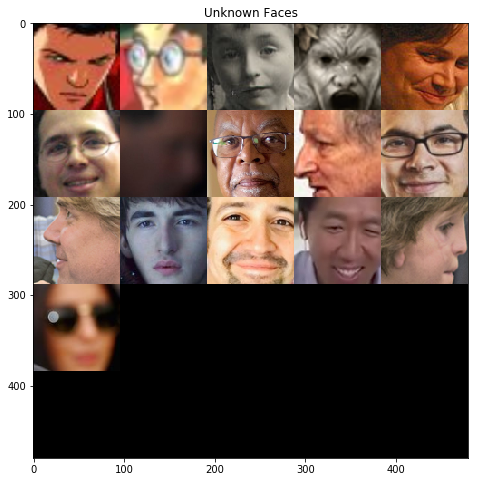

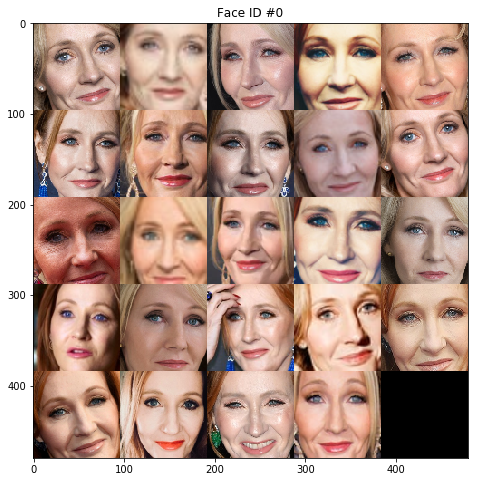

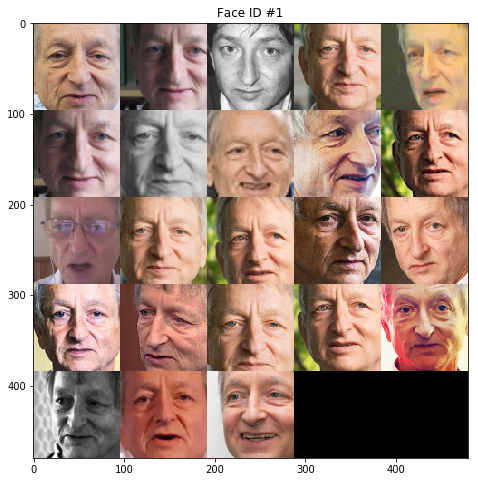

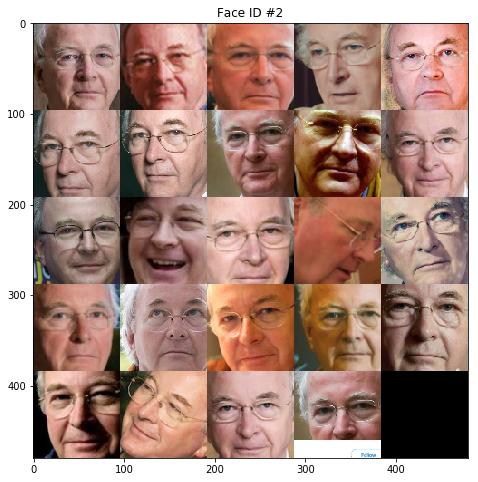

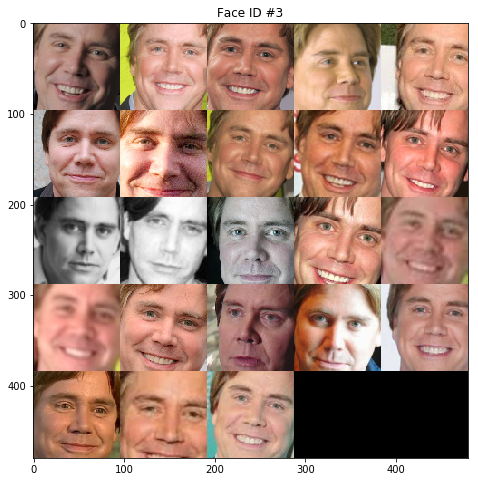

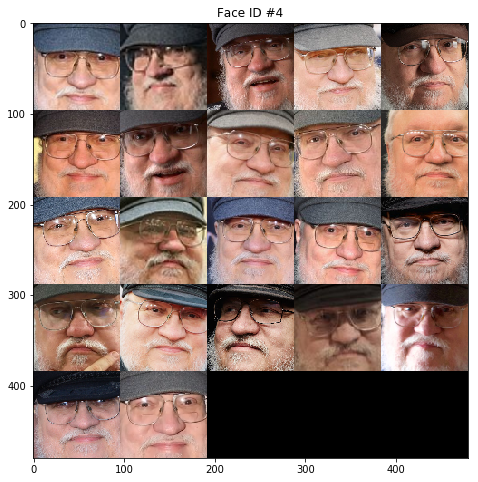

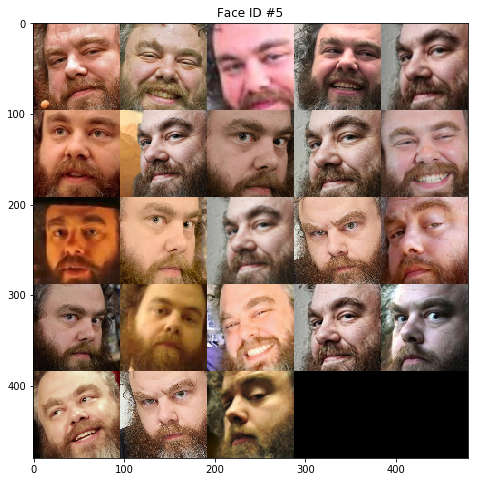

In [13]:
plot_clusters(data, clt, labelIDs, verbose=0)

## Znižovanie rozmeru pomocou t-SNE

Ďalej znížime rozmer dát zo 128 na 2 pomocou metódy t-SNE, aby sa dal priestor tvárí vizualizovať.

In [0]:
embeds = TSNE(n_components=2, init='random').fit_transform(encodings)
embeds -= embeds.min(axis=0)
embeds /= embeds.max(axis=0)

Definujeme metódu ``plot_faces``,  ktorá vykreslí príslušné tváre na zadaných pozíciách.

In [0]:
def plot_faces(data, poses, w=0.08, h=0.08, ax=None):
  ax = plt.gca()
  
  for i in range(len(data)):
    try:
        image = cv2.imread(data[i]['imagePath'])
        shape = data[i]["shape"]
        image = cv2.resize(image, (shape[1], shape[0]))
        
        (top, right, bottom, left) = data[i]["loc"]
        face = image[top:bottom, left:right]
        face = cv2.resize(face, (96, 96))
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        
        pos = poses[i]
        ax.imshow(face, extent=[pos[0] - w/2, pos[0] + w/2,
                                 pos[1] - h/2, pos[1] + h/2])
    except:
        pass
  
  plt.xlim([np.min(poses[:, 0]) - w, np.max(poses[:, 0]) + w])
  plt.ylim([np.min(poses[:, 1]) - h, np.max(poses[:, 1]) + h])

Pomocou metódy ``plot_faces`` vykreslíme tváre.

Text(0, 0.5, '$d_2$')

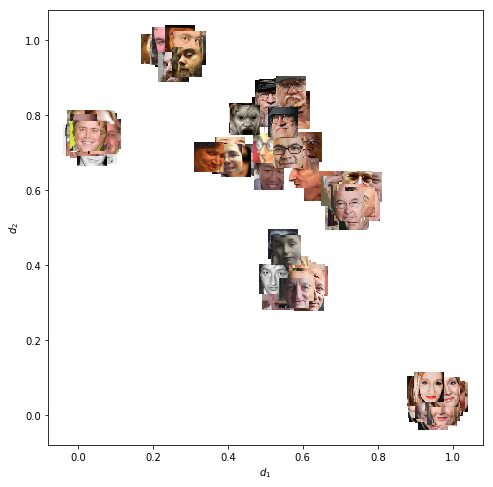

In [44]:
plt.figure(figsize=(10, 8))
plot_faces(data, embeds)
plt.xlabel('$d_1$')
plt.ylabel('$d_2$')

## Zobrazenie v mriežke pomocou algoritmu Jonker-Volgenant

V rámci vizualizácie vytvorenej pomocou t-SNE vidno vzdialenosti medzi zhlukmi tvárí a podobne. Obrázky sa však navzájom prekrývajú, čo robí obrázok ťažko čitateľným. Preto pozície skúsime premietnuť do pravidelnej mriežky pomocou algoritmu Jonker-Volgenant.

In [0]:
sqrt_size = int(np.ceil(np.sqrt(len(embeds))))
size = sqrt_size * sqrt_size
grid = np.dstack(np.meshgrid(np.linspace(0, 1, sqrt_size), np.linspace(0, 1, sqrt_size))).reshape(-1, 2)

padded_embeds = np.zeros((size, embeds.shape[1]))
padded_embeds[:embeds.shape[0], :] = embeds

cost_matrix = cdist(grid, padded_embeds, "sqeuclidean").astype(np.float32)
cost_matrix = cost_matrix * (100000 / cost_matrix.max())
row_as, col_as, _ = lapjv(cost_matrix)
grid_jv = grid[col_as]

Nové pozície fotografií uložené v poli ``grid_jv`` použijeme na vykreslenie.

In [45]:
plt.figure(figsize=(12, 12))
plot_faces(data, grid_jv)
plt.axis('off')

(-0.08, 1.08, -0.08, 1.08)

<div style="background-color: #C2EB66; padding: 15px; padding-top: 5px; margin-top: 10px; margin-left:-15px">
<h2>Úloha 1</h2>

Skúste ten istý proces aplikovať na fotografie iných ľudí.
</div>

<div style="background-color: #C2EB66; padding: 15px; padding-top: 5px; margin-top: 10px; margin-left:-15px">
<h2>Úloha 2</h2>

Pokúste sa podobný prístup aplikovať na úlohu rozpoznávania ľudských tvárí pomocou metódy KNN.
  
Pomôcky:
<ul>
 <li>Tréningová dátová množina bude obsahovať jeden alebo niekoľko obrázkov tvárí každého človeka, ktorého tvár sa má vedieť rozpoznať.</li>
<li>Ak nebude tvár dostatočne blízko žiadneho bodu, mala by sa označiť ako tvár neznámeho človeka.</li>
  </ul>
</div>